In this notebook we'll train a classifier to find **point behaviors** in inertial sensor data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sktime.classification.compose import TimeSeriesForestClassifier, ColumnEnsembleClassifier
from sktime.utils.data_container import from_3d_numpy_to_nested
from typing import List

Generate dummy sensor data and randomly assign events

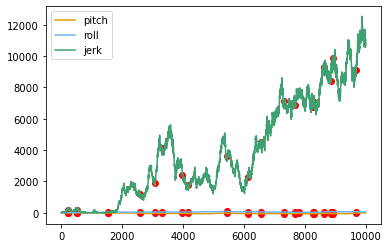

In [2]:
def random_sensor(n):
    return np.random.uniform(low=-1, high=1, size=n).cumsum()
N = 10000
sensors = pd.DataFrame(
    {
        "pitch": random_sensor(N),
        "roll": random_sensor(N),
        "jerk": random_sensor(N)**2
    }
)
N_events = 20
events = np.random.choice(range(N), size=N_events, replace=False)
events.sort()

# Plot dummy sensor data
sensors.plot.line(y=["pitch", "roll", "jerk"], color=["#DD9A00", "#6AB5EC", "#3FA072"])
for y in ["pitch", "roll", "jerk"]:
    plt.scatter(x=events, y=y, data=sensors.iloc[events], marker="o", color="red")

# How do I make the red points appear over the lines?

Create the training dataset consisting of **all** positive (i.e., the events) and an equal sample size of negatives (randomly selected). We'll use 20 record windows and make sure negative sample windows don't overlap the positives.

In [3]:
# Negatives must be 10 records removed from a positive
win_size = 20
positives = events

def diff_from(xs: np.ndarray, ys: np.ndarray) -> np.ndarray:
    """
    Return the array-wise least difference from another array
    
        Parameters:
            xs: the basis array
            ys: the target array
            
        Returns:
            The minimum absolute difference for each element of xs from the closest value in ys
    """
    return np.array([np.min(np.abs(x - ys)) for x in xs])

# Valid indices for negatives
negative_choices = np.array(range(win_size, len(sensors.index) - win_size - 1, win_size))
diff_from_pos = diff_from(negative_choices, positives)
diff_from_pos > win_size
negative_choices = negative_choices[diff_from_pos > win_size]

# Randomly choose 
negatives = np.random.choice(negative_choices, size=len(positives), replace=False)
negatives.sort()

print("+: " + str(positives))
print("-: " + str(negatives))

+: [ 210  531 1550 2586 3073 3317 3981 4154 5457 6127 6545 7302 7693 7815
 8269 8301 8619 8847 8912 9676]
-: [ 340  440  660 1200 1220 1620 2140 2300 3220 3380 4280 4700 4940 6620
 6940 7380 9220 9260 9400 9860]


Convert positives and negatives to sktime-compatible format

In [5]:
def extract_nested(data: pd.DataFrame, idx: List[int], window_size: int, label: str) -> pd.DataFrame:
    """
    Combine samples and reformat for sktime
    
        Parameters:
            data: longitudinal sensor data
            idx: indices of sample centers
            window_size: number of records in each sample window
            category: name of label (e.g., "positive" or "negative")
        
        Returns:
            Sample windows in nested sktime DataFrame format
    """
    # Create a 3d numpy array of breath data
    breaths_3d = np.empty([len(idx), len(data.columns), window_size], float)
    data_arr = data.to_numpy().transpose()
    start_idx = idx - int(window_size / 2)
    for i, start in enumerate(start_idx):
        breaths_3d[i] = data_arr[:, start:(start + window_size)]

    # Convert 3d numpy array to nested sktime DataFrame format
    nested = from_3d_numpy_to_nested(breaths_3d)
    nested.columns = data.columns
    nested["label"] = label
    nested.index = idx
    
    return nested

clf_data = pd.concat([extract_nested(sensors, positives, win_size, "pos"),
                      extract_nested(sensors, negatives, win_size, "neg")])